# Черновой вариант решения задачи об оценке стоимости автомобиля
## Общая обзорная часть

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 50) 
#cars = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200618_auto_bd_100_do_Ekata.csv", sep=';', encoding='utf-8')
# cars = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd_50_do_niznego.csv", sep=';', encoding='utf-8')
#cars1 = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd.100_do_Rostova.csv", sep=';', encoding='utf-8')
cars = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd_200629_100_do_Rossiya.csv", sep=';', encoding='utf-8')
cars1 = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd.100_do_Rostova.csv", sep=';', encoding='utf-8')
cars2 = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200629_auto_bd._200629_do_Omska.csv", sep=';', encoding='utf-8')
cars3 = pd.read_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\auto_bd.csv", sep=';', encoding='utf-8')
cars = pd.concat([cars, cars1, cars2, cars3], ignore_index=True)
cars.drop_duplicates(inplace=True)
#cars.reset_index(inplace=True)
#cars.to_csv('d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200620_auto_bd_100_merged.csv', sep=';', encoding='utf-8')
cars.head(5)

,brand,name,modelDate,color,productionDate,bodyType,fuelType,numberOfDoors,vehicleConfiguration,vehicleTransmission,engineDisplacement,whilleType,drive,enginePower,href,kmAge,place,VIN,seller,#owners,inUse,pts,condition,tax,castoms,exchange,comlpectation,price,priceCurrency
0,BMW,BMW 5 серия VI (F10/F11/F07) 530d xDrive,2009,чёрный,2012,седан,дизель,4,SEDAN AUTOMATIC 3.0,автоматическая,3.0 LTR,Левый,полный,258 N12,https://auto.ru/cars/used/sale/bmw/5er/1098832...,177 000 км,Москва,X4X**************,Private,3 или более,0,Оригинал,Не требует ремонта,38 700 ₽ / год,Растаможен,NaN,NaN,950000.0,RUB
1,BMW,BMW 5 серия VII (G30/G31) 520d xDrive,2016,синий,2019,седан,дизель,4,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,Левый,полный,190 N12,https://auto.ru/cars/used/sale/bmw/5er/1098730...,6 000 км,Москва,X4X**************,Private,1 владелец,6 месяцев,Оригинал,Не требует ремонта,10 450 ₽ / год,Растаможен,NaN,"Круиз-контроль,Мультифункциональное рулевое ко...",2745000.0,RUB
2,FIAT,Fiat 125,1967,жёлтый,1973,седан,бензин,4,SEDAN MECHANICAL 1.6,механическая,1.6 LTR,Левый,задний,100 N12,https://auto.ru/cars/used/sale/fiat/125/109786...,3 600 км,Москва,NaN,Private,1 владелец,23 года и 3 месяца,Оригинал,Не требует ремонта,1 200 ₽ / год,Растаможен,NaN,NaN,235000.0,RUB
3,FORD,Ford Focus II Рестайлинг,2007,серебристый,2008,седан,бензин,4,SEDAN MECHANICAL 1.8,механическая,1.8 LTR,Левый,передний,125 N12,https://auto.ru/cars/used/sale/ford/focus/1098...,117 246 км,Москва,WF0**************,Автосалон «Независимость Авто»,2 владельца,0,Оригинал,Не требует ремонта,3 125 ₽ / год,Растаможен,NaN,"Подушка безопасности водителя,Крепление детско...",325000.0,RUB
4,RENAULT,Renault Logan II Рестайлинг,2018,белый,2020,седан,бензин,4,SEDAN MECHANICAL 1.6,механическая,1.6 LTR,NaN,Передний,113 N12,https://auto.ru/cars/new/group/renault/logan/2...,Новый,Химки,NaN,Автомир Renault Химки,0,0,NaN,NaN,3 842 ₽ / год,NaN,NaN,"Защита картера,Полноразмерное запасное колесо,...",749000.0,RUB


In [2]:
# Функция для вывода со статисчтической иноформацией о признаке
def feature_info(_column, _bins = 0, _normalize=True, _values=False, _threshold=10):
    
    if(_bins==0):
        _bins = len(_column.value_counts(dropna=True, normalize=_normalize))
            
    print(f"Тип признака: {_column.dtype}\nЗначения признака:")
    
    
    if _column.dtype != 'object':
        _column.hist(bins = _bins, align='left')
        display(_column.describe())
        if _values == True:
            display(pd.DataFrame(_column.value_counts(dropna=False, normalize=_normalize).round(3)))
       # plt.plot(_column,pupils['score'])
    
    else:
        display(pd.DataFrame(_column.value_counts(dropna=False, normalize=_normalize).round(3)))
    
    print(f"Различных значений c учётом NaN: {len(_column.value_counts(dropna=False, normalize=_normalize))}\n\
              \t  без учёта NaN: {len(_column.value_counts(dropna=True, normalize=_normalize))} \nПропусков: {_column.isnull().sum()}")
    print(f"Значений, встретившихся в столбце более {_threshold} раз:"#Число 10 взято для ориентира, можно брать другое
      , (_column.value_counts()>_threshold).sum())
    

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109646 entries, 0 to 125062
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   brand                 109646 non-null  object 
 1   name                  109646 non-null  object 
 2   modelDate             109646 non-null  int64  
 3   color                 109646 non-null  object 
 4   productionDate        109646 non-null  int64  
 5   bodyType              109646 non-null  object 
 6   fuelType              109646 non-null  object 
 7   numberOfDoors         109646 non-null  int64  
 8   vehicleConfiguration  109646 non-null  object 
 9   vehicleTransmission   109646 non-null  object 
 10  engineDisplacement    109646 non-null  object 
 11  whilleType            93353 non-null   object 
 12  drive                 109572 non-null  object 
 13  enginePower           109646 non-null  object 
 14  href                  109646 non-null  object 
 15  

### brand

In [4]:
cars[cars.brand == 'BMW'].to_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\BMW_char.csv", sep=';', 
            encoding='utf-8', index=False )

In [5]:
feature_info(cars.brand, _normalize=False, _threshold=100)

Тип признака: object
Значения признака:


,brand
VAZ,15438
KIA,8163
HYUNDAI,8031
TOYOTA,7371
NISSAN,6500
...,...
GAC,1
BAJAJ,1
DADI,1
TIANMA,1


Различных значений c учётом NaN: 110
              	  без учёта NaN: 110 
Пропусков: 0
Значений, встретившихся в столбце более 100 раз: 45


### name

In [6]:
feature_info(cars.name, _normalize=False, _threshold=100)

Тип признака: object
Значения признака:


,name
LADA (ВАЗ) Granta I,1730
LADA (ВАЗ) Priora I,1184
LADA (ВАЗ) Vesta I,1134
LADA (ВАЗ) Granta I Рестайлинг,1051
LADA (ВАЗ) Kalina I,1009
...,...
Ford Focus (North America) I Рестайлинг,1
Ferrari F12berlinetta,1
Citroen C1 II,1
Lexus RC I 350,1


Различных значений c учётом NaN: 3827
              	  без учёта NaN: 3827 
Пропусков: 0
Значений, встретившихся в столбце более 100 раз: 245


In [7]:
cars[cars.brand=='BMW'].name.value_counts()

BMW 5 серия  VII (G30/G31) 520d xDrive                     76
BMW X6  I (E71) 35i                                        75
BMW 5 серия  VII (G30/G31) 530d xDrive                     69
BMW X6  II (F16) 30d                                       68
BMW X5  II (E70) Рестайлинг 35i                            64
                                                           ..
BMW 7 серия  III (E38) 728i                                 1
BMW 3 серия  V (E90/E91/E92/E93) Рестайлинг 320d xDrive     1
BMW 3 серия  IV (E46) 330i                                  1
BMW 5 серия  IV (E39) 535i                                  1
BMW 7 серия Long VI (G11/G12) 725Ld                         1
Name: name, Length: 412, dtype: int64

### modelDate

Тип признака: int64
Значения признака:


count    109646.000000
mean       2008.570326
std           7.941361
min        1934.000000
25%        2005.000000
50%        2010.000000
75%        2014.000000
max        2020.000000
Name: modelDate, dtype: float64

Различных значений c учётом NaN: 68
              	  без учёта NaN: 68 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 50


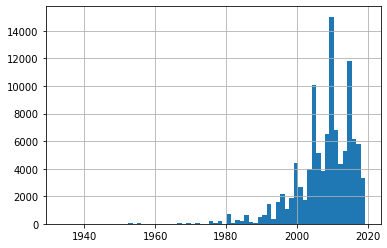

In [8]:
feature_info(cars.modelDate)

### color

In [9]:
feature_info(cars.color)

Тип признака: object
Значения признака:


,color
белый,0.218
чёрный,0.217
серебристый,0.152
серый,0.125
синий,0.081
красный,0.055
коричневый,0.045
зелёный,0.033
бежевый,0.026
голубой,0.015


Различных значений c учётом NaN: 16
              	  без учёта NaN: 16 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 16


### productionDate

Тип признака: int64
Значения признака:


count    109646.000000
mean       2011.566870
std           6.660284
min        1934.000000
25%        2008.000000
50%        2012.000000
75%        2017.000000
max        2020.000000
Name: productionDate, dtype: float64

Различных значений c учётом NaN: 74
              	  без учёта NaN: 74 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 43


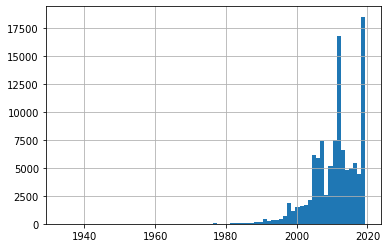

In [10]:
feature_info(cars.productionDate)

### bodyType

In [11]:
feature_info(cars.bodyType)

Тип признака: object
Значения признака:


,bodyType
седан,0.355
внедорожник 5 дв.,0.346
хэтчбек 5 дв.,0.142
универсал 5 дв.,0.048
лифтбек,0.033
компактвэн,0.017
хэтчбек 3 дв.,0.015
внедорожник 3 дв.,0.013
минивэн,0.013
купе,0.007


Различных значений c учётом NaN: 26
              	  без учёта NaN: 26 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 20


Есть отдельный признак, в котором хранится количество дверей, поэтому удалим его из этого признака

In [12]:
cars.bodyType = cars.bodyType.apply(lambda x: re.sub("\d дв\.", "", x))
feature_info(cars.bodyType)

Тип признака: object
Значения признака:


,bodyType
внедорожник,0.359
седан,0.355
хэтчбек,0.157
универсал,0.048
лифтбек,0.033
компактвэн,0.017
минивэн,0.013
купе,0.007
пикап двойная кабина,0.006
фургон,0.002


Различных значений c учётом NaN: 22
              	  без учёта NaN: 22 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 18


### fuelType  

In [13]:
feature_info(cars.fuelType)

Тип признака: object
Значения признака:


,fuelType
бензин,0.892
дизель,0.104
гибрид,0.003
электро,0.001
газ,0.000


Различных значений c учётом NaN: 5
              	  без учёта NaN: 5 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 5


### numberOfDoors

Тип признака: int64
Значения признака:


count    109646.000000
mean          4.547745
std           0.599995
min           2.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: numberOfDoors, dtype: float64

Различных значений c учётом NaN: 4
              	  без учёта NaN: 4 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


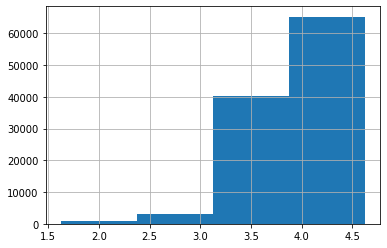

In [14]:
feature_info(cars.numberOfDoors)

### vehicleConfiguration

In [15]:
feature_info(cars.vehicleConfiguration)

Тип признака: object
Значения признака:


,vehicleConfiguration
SEDAN MECHANICAL 1.6,0.102
ALLROAD_5_DOORS AUTOMATIC 2.0,0.061
SEDAN AUTOMATIC 1.6,0.048
HATCHBACK_5_DOORS MECHANICAL 1.6,0.046
ALLROAD_5_DOORS AUTOMATIC 3.0,0.034
...,...
ROADSTER AUTOMATIC 6.2,0.000
LIFTBACK AUTOMATIC 2.2,0.000
WAGON_5_DOORS AUTOMATIC 4.2,0.000
HATCHBACK_5_DOORS MECHANICAL 2.4,0.000


Различных значений c учётом NaN: 745
              	  без учёта NaN: 745 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 362


Информация этого признака представлена другими отдельными признаками, поэтому его можно удалить

In [16]:
cars.drop(['vehicleConfiguration'], axis=1, inplace=True)

### vehicleTransmission

In [17]:
feature_info(cars.vehicleTransmission)

Тип признака: object
Значения признака:


,vehicleTransmission
автоматическая,0.429
механическая,0.427
вариатор,0.080
роботизированная,0.064


Различных значений c учётом NaN: 4
              	  без учёта NaN: 4 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


### engineDisplacement

In [18]:
feature_info(cars.engineDisplacement)

Тип признака: object
Значения признака:


,engineDisplacement
1.6 LTR,0.321
2.0 LTR,0.192
1.4 LTR,0.064
1.5 LTR,0.061
1.8 LTR,0.055
...,...
7.0 LTR,0.000
0.2 LTR,0.000
0.4 LTR,0.000
8.3 LTR,0.000


Различных значений c учётом NaN: 68
              	  без учёта NaN: 68 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 51


Избавимся от окончания LTR и переведём признак в числовой предварительно избавившись от значения undefined, заменив его на самое частое

Тип признака: float64
Значения признака:


count    109646.000000
mean          1.997432
std           0.737871
min           0.200000
25%           1.600000
50%           1.700000
75%           2.000000
max           8.300000
Name: engineDisplacement, dtype: float64

Различных значений c учётом NaN: 67
              	  без учёта NaN: 67 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 50


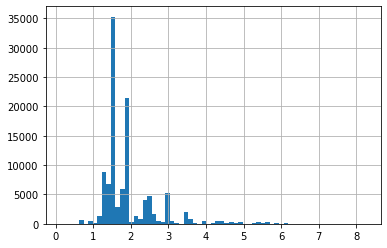

In [19]:
cars.engineDisplacement = cars.engineDisplacement.apply(lambda x: "1.6 LTR" if x=='undefined LTR' else x)
cars.engineDisplacement = cars.engineDisplacement.apply(lambda x: (re.sub(" LTR", "", x))).astype(float)
feature_info(cars.engineDisplacement)

### whilleType

In [20]:
feature_info(cars.whilleType)

Тип признака: object
Значения признака:


,whilleType
Левый,0.816
NaN,0.149
Правый,0.036


Различных значений c учётом NaN: 3
              	  без учёта NaN: 2 
Пропусков: 16293
Значений, встретившихся в столбце более 10 раз: 2


Пропуски образовались у новых автомобилей из-за особенностей разбора, заменим их на левый (новые автомобили в РФ только с левым рулём)

In [21]:
cars.whilleType.fillna('Левый', inplace=True)

In [22]:
feature_info(cars.whilleType)

Тип признака: object
Значения признака:


,whilleType
Левый,0.964
Правый,0.036


Различных значений c учётом NaN: 2
              	  без учёта NaN: 2 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 2


### drive

In [23]:
feature_info(cars.drive)

Тип признака: object
Значения признака:


,drive
передний,0.529
полный,0.272
Передний,0.084
Полный,0.062
задний,0.050
Задний,0.002
NaN,0.001
Автоматическая,0.000


Различных значений c учётом NaN: 8
              	  без учёта NaN: 7 
Пропусков: 74
Значений, встретившихся в столбце более 10 раз: 7


In [24]:
cars.drive = cars.drive.str.lower()
feature_info(cars.drive)

Тип признака: object
Значения признака:


,drive
передний,0.613
полный,0.334
задний,0.053
NaN,0.001
автоматическая,0.000


Различных значений c учётом NaN: 5
              	  без учёта NaN: 4 
Пропусков: 74
Значений, встретившихся в столбце более 10 раз: 4


### enginePower

In [25]:
feature_info(cars.enginePower)

Тип признака: object
Значения признака:


,enginePower
150 N12,0.079
123 N12,0.035
87 N12,0.031
105 N12,0.027
249 N12,0.026
...,...
492 N12,0.000
710 N12,0.000
56 N12,0.000
338 N12,0.000


Различных значений c учётом NaN: 386
              	  без учёта NaN: 386 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 265


In [26]:
cars.enginePower = cars.enginePower.apply(lambda x: (re.sub(" N12", "", x))).astype(int)

Тип признака: int32
Значения признака:


count    109646.000000
mean        145.131085
std          70.793600
min          12.000000
25%         102.000000
50%         125.000000
75%         166.000000
max        1500.000000
Name: enginePower, dtype: float64

Различных значений c учётом NaN: 386
              	  без учёта NaN: 386 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 265


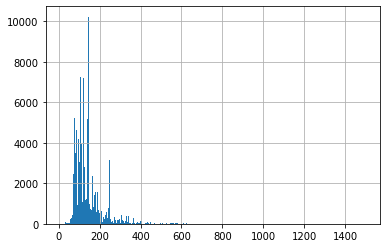

In [27]:
feature_info(cars.enginePower)

### href

In [28]:
feature_info(cars.href)

Тип признака: object
Значения признака:


,href
https://auto.ru/cars/used/sale/nissan/note/1097759496-041c4792/,0.0
https://auto.ru/cars/used/sale/vaz/largus/1098876766-7c751677/,0.0
https://auto.ru/cars/used/sale/bmw/x6_m/1087702466-6f4dcea6/,0.0
https://auto.ru/cars/used/sale/bmw/5er/1099071054-f137e727/,0.0
https://auto.ru/cars/used/sale/mitsubishi/pajero_sport/1098885604-201bc9b7/,0.0
...,...
https://auto.ru/cars/used/sale/vaz/granta/1098926494-9e944e62/,0.0
https://auto.ru/cars/new/group/renault/logan/21335454/21335612/1096762802-96d5234a/,0.0
https://auto.ru/cars/used/sale/volkswagen/tiguan/1098882408-8463cee0/,0.0
https://auto.ru/cars/new/group/kia/rio/21028061/21042836/1099123747-4fc58418/,0.0


Различных значений c учётом NaN: 93093
              	  без учёта NaN: 93093 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 0


### kmAge

In [29]:
feature_info(cars.kmAge)

Тип признака: object
Значения признака:


,kmAge
Новый,0.149
200 000 км,0.012
150 000 км,0.012
120 000 км,0.010
180 000 км,0.009
...,...
192 003 км,0.000
45 577 км,0.000
88 266 км,0.000
127 559 км,0.000


Различных значений c учётом NaN: 20703
              	  без учёта NaN: 20703 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 502


In [30]:
cars.kmAge = cars.kmAge.apply(lambda x: (re.sub("км", "", x)))
cars.kmAge = cars.kmAge.apply(lambda x: (re.sub("Новый", "0", x)))
cars.kmAge = cars.kmAge.apply(lambda x: (re.sub("\xa0", "", x))).astype(int)


Тип признака: int32
Значения признака:


count     109646.000000
mean      113826.995248
std        90295.152026
min            0.000000
25%        44000.000000
50%       106900.000000
75%       165000.000000
max      1000000.000000
Name: kmAge, dtype: float64

Различных значений c учётом NaN: 20703
              	  без учёта NaN: 20703 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 502


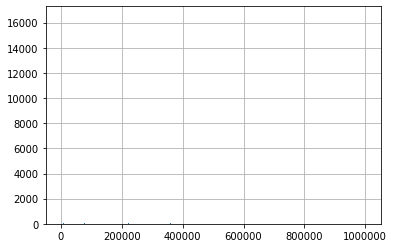

In [31]:
feature_info(cars.kmAge)

###  place

In [32]:
feature_info(cars.place)

Тип признака: object
Значения признака:


,place
Нижний Новгород,0.063
Екатеринбург,0.061
Краснодар,0.060
Новосибирск,0.059
Красноярск,0.057
...,...
Плешки,0.000
Долгопрудный,0.000
Глазки,0.000
Анапа,0.000


Различных значений c учётом NaN: 303
              	  без учёта NaN: 302 
Пропусков: 1095
Значений, встретившихся в столбце более 10 раз: 89


In [33]:
cars.place.fillna('Неизвестно', inplace = True)

### VIN

In [34]:
feature_info(cars.VIN)

Тип признака: object
Значения признака:


,VIN
NaN,0.183
XTA**************,0.115
XW8**************,0.041
Z94**************,0.036
XWE**************,0.034
...,...
NCP**************,0.000
RNU12-***********,0.000
Y7D**************,0.000
GH12-1***********,0.000


Различных значений c учётом NaN: 814
              	  без учёта NaN: 813 
Пропусков: 20055
Значений, встретившихся в столбце более 10 раз: 197


In [35]:
cars.VIN.fillna('XXX', inplace=True)
cars.VIN = cars.VIN.apply(lambda x: (re.sub("\*", "", x)))
feature_info(cars.VIN)

Тип признака: object
Значения признака:


,VIN
XXX,0.183
XTA,0.115
XW8,0.041
Z94,0.036
XWE,0.034
...,...
DFJ,0.000
XWP,0.000
K96,0.000
2A8,0.000


Различных значений c учётом NaN: 813
              	  без учёта NaN: 813 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 198


### seller

In [36]:
feature_info(cars.seller)

Тип признака: object
Значения признака:


,seller
Private,0.560
БЦР MOTORS,0.008
Нижегородец Exchange на Комсомольском шоссе,0.005
КорсАвто,0.005
Юг-Авто Эксперт Яблоновский,0.005
...,...
CAR-TRADING,0.000
Башавтоком LADA Уфа,0.000
Урбан-Моторс,0.000
ВАДИО,0.000


Различных значений c учётом NaN: 1519
              	  без учёта NaN: 1519 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 816


In [37]:
cars.seller = cars.seller.apply(lambda x: 'Salon' if x!='Private' else x)
feature_info(cars.seller)

Тип признака: object
Значения признака:


,seller
Private,0.56
Salon,0.44


Различных значений c учётом NaN: 2
              	  без учёта NaN: 2 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 2


### #owners

In [38]:
feature_info(cars['#owners'])

Тип признака: object
Значения признака:


,#owners
3 или более,0.383
1 владелец,0.258
2 владельца,0.210
0,0.149


Различных значений c учётом NaN: 4
              	  без учёта NaN: 4 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


Тип признака: int32
Значения признака:


count    109646.000000
mean          1.828256
std           1.098226
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: #owners, dtype: float64

Различных значений c учётом NaN: 4
              	  без учёта NaN: 4 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 4


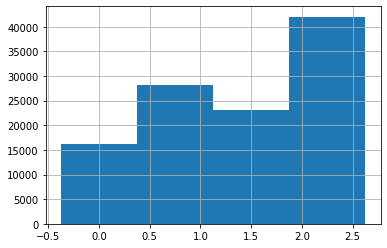

In [39]:
cars['#owners'] = cars['#owners'].apply(lambda x: (re.sub("\D", "", x))).astype(int)
feature_info(cars['#owners'])

### inUse

In [40]:
feature_info(cars.inUse)

Тип признака: object
Значения признака:


,inUse
0,0.662
9 месяцев,0.008
1 год и 4 месяца,0.008
1 год и 5 месяцев,0.006
1 год и 6 месяцев,0.006
...,...
21 год и 5 месяцев,0.000
22 года,0.000
30 лет и 6 месяцев,0.000
49 лет и 9 месяцев,0.000


Различных значений c учётом NaN: 339
              	  без учёта NaN: 339 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 179


In [41]:
def reshape_years(inuse):
    word = inuse.split(sep=' ')
    years = 0
    months = 0

    if len(word) >= 2:
        for i in range(0, len(word)):
            if word[i].isdigit() and word[i + 1][:3] == 'мес':
                months = int(word[i])
            elif word[i].isdigit() and (word[i + 1][:3] == 'лет' or word[i + 1][:3] == 'год'):
                years = int(word[i])
    return (years * 12 + months)   
    
cars['inUse']=cars.inUse.apply(reshape_years)

Тип признака: int64
Значения признака:


count    109646.000000
mean         17.284853
std          35.341215
min           0.000000
25%           0.000000
50%           0.000000
75%          19.000000
max         746.000000
Name: inUse, dtype: float64

Различных значений c учётом NaN: 339
              	  без учёта NaN: 339 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 179


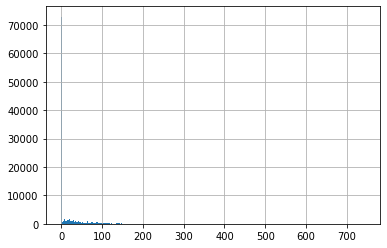

In [42]:
feature_info(cars.inUse)

### pts

In [43]:
feature_info(cars.pts)

Тип признака: object
Значения признака:


,pts
Оригинал,0.750
NaN,0.149
Дубликат,0.102


Различных значений c учётом NaN: 3
              	  без учёта NaN: 2 
Пропусков: 16293
Значений, встретившихся в столбце более 10 раз: 2


In [44]:
cars.pts.fillna('Оригинал', inplace=True)
feature_info(cars.pts)

Тип признака: object
Значения признака:


,pts
Оригинал,0.898
Дубликат,0.102


Различных значений c учётом NaN: 2
              	  без учёта NaN: 2 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 2


### condition

In [45]:
feature_info(cars.condition)

Тип признака: object
Значения признака:


,condition
Не требует ремонта,0.851
NaN,0.149
Битый / не на ходу,0.000


Различных значений c учётом NaN: 3
              	  без учёта NaN: 2 
Пропусков: 16293
Значений, встретившихся в столбце более 10 раз: 1


In [46]:
cars.condition.fillna('Другое',inplace=True)

### tax

In [47]:
feature_info(cars.tax)

Тип признака: object
Значения признака:


,tax
5 250 ₽ / год,0.015
18 675 ₽ / год,0.013
3 750 ₽ / год,0.012
2 175 ₽ / год,0.009
4 500 ₽ / год,0.009
...,...
256 950 ₽ / год,0.000
21 225 ₽ / год,0.000
9 261 ₽ / год,0.000
4 185 ₽ / год,0.000


Различных значений c учётом NaN: 2786
              	  без учёта NaN: 2786 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 1342


Тип признака: int32
Значения признака:


count    109646.000000
mean       7181.426536
std       15771.126827
min           0.000000
25%        1470.000000
50%        3150.000000
75%        5430.000000
max      400294.000000
Name: tax, dtype: float64

Различных значений c учётом NaN: 2785
              	  без учёта NaN: 2785 
Пропусков: 0
Значений, встретившихся в столбце более 10 раз: 1341


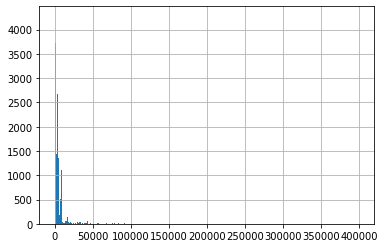

In [48]:
cars.tax = cars.tax.apply(lambda x: (re.sub("\D", "", x))).astype(int)
feature_info(cars.tax)

### castoms

In [49]:
feature_info(cars.castoms)

Тип признака: object
Значения признака:


,castoms
Растаможен,0.851
NaN,0.149


Различных значений c учётом NaN: 2
              	  без учёта NaN: 1 
Пропусков: 16293
Значений, встретившихся в столбце более 10 раз: 1


In [50]:
cars.castoms.fillna('Другое',inplace=True)

### exchange

In [51]:
feature_info(cars.exchange)

Тип признака: object
Значения признака:


,exchange
NaN,0.676
Рассмотрю варианты,0.324


Различных значений c учётом NaN: 2
              	  без учёта NaN: 1 
Пропусков: 74081
Значений, встретившихся в столбце более 10 раз: 1


In [52]:
cars.exchange.fillna('Нет',inplace=True)

### comlpectation

In [53]:
feature_info(cars.comlpectation)

Тип признака: object
Значения признака:


,comlpectation
NaN,0.481
"Защита картера,Сигнализация,",0.001
"ЭРА-ГЛОНАСС,Подушка безопасности водителя,Крепление детского кресла (задний ряд) ISOFIX,Подушка безопасности пассажира,Система помощи при торможении (BAS, EBD),Антиблокировочная система (ABS),Блокировка замков задних дверей,Тонированные стекла,Ткань (Материал салона),Подогрев передних сидений,USB,Аудиосистема,Bluetooth,Розетка 12V,Электростеклоподъёмники передние,Бортовой компьютер,Усилитель руля,Электропривод зеркал,Кондиционер,Регулировка руля по высоте,Полноразмерное запасное колесо,Центральный замок,Иммобилайзер,Дневные ходовые огни,Электрообогрев боковых зеркал,Стальные диски,Декоративные молдинги,Диски 14,",0.001
"Круиз-контроль,Электростеклоподъёмники передние,Мультифункциональное рулевое колесо,Бортовой компьютер,Усилитель руля,Электропривод зеркал,Электростеклоподъёмники задние,Парктроник передний,Регулировка руля по вылету,Регулировка руля по высоте,Климат-контроль 2-зонный,Электроскладывание зеркал,Парктроник задний,ЭРА-ГЛОНАСС,Антипробуксовочная система (ASR),Система стабилизации (ESP),Подушка безопасности водителя,Крепление детского кресла (задний ряд) ISOFIX,Система помощи при старте в гору (HSA),Подушки безопасности оконные (шторки),Подушка безопасности пассажира,Система помощи при торможении (BAS, EBD),Подушки безопасности боковые,Антиблокировочная система (ABS),USB,AUX,Аудиосистема,Bluetooth,Розетка 12V,Датчик света,Противотуманные фары,Датчик дождя,Электрообогрев боковых зеркал,Электрообогрев лобового стекла,Регулировка передних сидений по высоте,Передний центральный подлокотник,Складывающееся заднее сиденье,Ткань (Материал салона),Подогрев задних сидений,Обогрев рулевого колеса,Подогрев передних сидений,Отделка кожей рулевого колеса,Третий задний подголовник,Центральный замок,Иммобилайзер,Докатка,Диски 17,",0.001
"ЭРА-ГЛОНАСС,Система стабилизации (ESP),Подушка безопасности водителя,Крепление детского кресла (задний ряд) ISOFIX,Система помощи при старте в гору (HSA),Подушка безопасности пассажира,Система стабилизации рулевого управления (VSM),Система помощи при торможении (BAS, EBD),Датчик давления в шинах,Антиблокировочная система (ABS),USB,Аудиосистема,Bluetooth,Розетка 12V,Электростеклоподъёмники передние,Мультифункциональное рулевое колесо,Бортовой компьютер,Усилитель руля,Электропривод зеркал,Электростеклоподъёмники задние,Кондиционер,Регулировка руля по высоте,Складывающееся заднее сиденье,Ткань (Материал салона),Регулировка сиденья водителя по высоте,Подогрев передних сидений,Сигнализация,Центральный замок,Иммобилайзер,Стальные диски,Диски 15,Электрообогрев боковых зеркал,",0.001
...,...
"Защита картера,Полноразмерное запасное колесо,Тонированные стекла,Передний центральный подлокотник,Ткань (Материал салона),Тёмный салон,Отделка потолка чёрной тканью,Подушка безопасности водителя,AUX,USB,Bluetooth,Розетка 12V,Электростеклоподъёмники передние,Прикуриватель и пепельница,Бортовой компьютер,Усилитель руля,Электропривод зеркал,Электронная приборная панель,Электропривод крышки багажника,Регулировка руля по высоте,Центральный замок,Иммобилайзер,Легкосплавные диски,Декоративные молдинги,Диски 14,",0.000
"Защита картера,Полноразмерное запасное колесо,Тонированные стекла,Ткань (Материал салона),Тёмный салон,Подушка безопасности водителя,Антиблокировочная система (ABS),USB,Аудиоподготовка,Bluetooth,Электростеклоподъёмники передние,Бортовой компьютер,Усилитель руля,Электропривод зеркал,Регулировка руля по высоте,Климат-контроль 1-зонный,Сигнализация,Центральный замок,Иммобилайзер,Легкосплавные диски,Металлик,Диски 14,Противотуманные фары,Электрообогрев боковых зеркал,",0.000
"Тонированные стекла,Регулировка передних сидений по высоте,Передний центральный подлокотник,Ткань (Материал салона),Отделка кожей рычага КПП,Количество мест: 7,Третий ряд сидений,Система стабилизации (ESP),Подушка безопасности водителя,Подушка безопасности пассажира,Антиблокировочная система (ABS),Электростеклоподъёмники передние,Мультифункциональное рулевое колесо,Бортовой компь

Различных значений c учётом NaN: 45421
              	  без учёта NaN: 45420 
Пропусков: 52794
Значений, встретившихся в столбце более 10 раз: 217


In [54]:
#cars.comlpectation.fillna('', inplace =True)

In [55]:
from collections import defaultdict
most_valueble_options = ['led_lights','tyres_contol', 'elecrtic_back', 'electic_rear_seats', 'bottom_start', 'window_airbag',
               'no_key', 'electrick_mirror', 'anti_crash', 'hsa', 'rain_control', 'leather', 'warm_wheel', 'light_control',
               'premium_audio', 'line_control', 'rear_sits_memory', 'start_stop', 'leather_wheel', 'wheel_controls',
                'navigation'] # Получен на основе корреляционного анализа с целевой переменной
def proc_complectation(x): 
    if pd.isnull(x):
        return []
    else:
        x = x.replace('Светодиодные фары', 'led_lights')
        x = x.replace('Датчик давления в шинах', 'tyres_contol')
        x = x.replace('Электропривод крышки багажника', 'elecrtic_back')
        x = x.replace('Электрорегулировка передних сидений', 'electic_rear_seats')
        x = x.replace('Запуск двигателя с кнопки', 'bottom_start')
        x = x.replace('Подушки безопасности оконные (шторки)', 'window_airbag')
        x = x.replace('Система доступа без ключа', 'no_key')
        x = x.replace('Электроскладывание зеркал', 'electrick_mirror')
        x = x.replace('Система предотвращения столкновения', 'anti_crash')
        x = x.replace('Система помощи при старте в гору (HSA)', 'hsa')
        x = x.replace('Датчик дождя', 'rain_control')
        x = x.replace('Кожа (Материал салона)', 'leather')
        x = x.replace('Обогрев рулевого колеса', 'warm_wheel')
        x = x.replace('Датчик света', 'light_control')
        x = x.replace('Премиальная аудиосистема', 'premium_audio')
        x = x.replace('Система контроля за полосой движения', 'line_control')
        x = x.replace('Память передних сидений', 'rear_sits_memory')
        x = x.replace('Система «старт-стоп»', 'start_stop')
        x = x.replace('Отделка кожей рулевого колеса', 'leather_wheel')
        x = x.replace('Мультифункциональное рулевое колесо', 'leather_wheel')
        x = x.replace('Подрулевые лепестки переключения передач', 'wheel_controls')
        x = x.replace('Навигационная система', 'navigation')
        items = x.split(sep=',')
        items.remove('')
        return items

def fill_components_item(value):
    if item in value:
        return 1
    else:
        return 0

In [56]:
cars['comlpectation'] = cars['comlpectation'].apply(proc_complectation)
cars['num_options'] = cars['comlpectation'].apply(lambda x: len(x))

In [57]:
complectation_items = defaultdict(int)
for value in cars['comlpectation']:
    for item in value:
         complectation_items[item] += 1

In [58]:
for item in most_valueble_options:
    cars[item] = cars['comlpectation'].apply(fill_components_item)
cars

,brand,name,modelDate,color,productionDate,bodyType,fuelType,numberOfDoors,vehicleTransmission,engineDisplacement,whilleType,drive,enginePower,href,kmAge,place,VIN,seller,#owners,inUse,pts,condition,tax,castoms,exchange,comlpectation,price,priceCurrency,num_options,led_lights,tyres_contol,elecrtic_back,electic_rear_seats,bottom_start,window_airbag,no_key,electrick_mirror,anti_crash,hsa,rain_control,leather,warm_wheel,light_control,premium_audio,line_control,rear_sits_memory,start_stop,leather_wheel,wheel_controls,navigation
0,BMW,BMW 5 серия VI (F10/F11/F07) 530d xDrive,2009,чёрный,2012,седан,дизель,4,автоматическая,3.0,Левый,полный,258,https://auto.ru/cars/used/sale/bmw/5er/1098832...,177000,Москва,X4X,Private,3,0,Оригинал,Не требует ремонта,38700,Растаможен,Нет,[],950000.0,RUB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BMW,BMW 5 серия VII (G30/G31) 520d xDrive,2016,синий,2019,седан,дизель,4,автоматическая,2.0,Левый,полный,190,https://auto.ru/cars/used/sale/bmw/5er/1098730...,6000,Москва,X4X,Private,1,6,Оригинал,Не требует ремонта,10450,Растаможен,Нет,"[Круиз-контроль, leather_wheel, Система автома...",2745000.0,RUB,59,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,0,0,1,1,0,1
2,FIAT,Fiat 125,1967,жёлтый,1973,седан,бензин,4,механическая,1.6,Левый,задний,100,https://auto.ru/cars/used/sale/fiat/125/109786...,3600,Москва,XXX,Private,1,279,Оригинал,Не требует ремонта,1200,Растаможен,Нет,[],235000.0,RUB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,FORD,Ford Focus II Рестайлинг,2007,серебристый,2008,седан,бензин,4,механическая,1.8,Левый,передний,125,https://auto.ru/cars/used/sale/ford/focus/1098...,117246,Москва,WF0,Salon,2,0,Оригинал,Не требует ремонта,3125,Растаможен,Нет,"[Подушка безопасности водителя, Крепление детс...",325000.0,RUB,26,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,RENAULT,Renault Logan II Рестайлинг,2018,белый,2020,седан,бензин,4,механическая,1.6,Левый,передний,113,https://auto.ru/cars/new/group/renault/logan/2...,0,Химки,XXX,Salon,0,0,Оригинал,Другое,3842,Другое,Нет,"[Защита картера, Полноразмерное запасное колес...",749000.0,RUB,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125037,BMW,BMW 2 серия Gran Coupe F44 218i,2019,белый,2020,седан,бензин,4,роботизированная,1.5,Левый,передний,140,https://auto.ru/cars/new/group/bmw/2er/2169196...,0,Москва,XXX,Salon,0,0,Оригинал,Другое,4900,Другое,Нет,"[Круиз-контроль, leather_wheel, Система автома...",2554200.0,RUB,59,1,1,0,0,1,1,0,1,0,0,1,0,1,1,1,0,0,0,1,0,0
125043,BMW,BMW X5 IV (G05) 30d,2018,белый,2020,внедорожник,дизель,5,автоматическая,3.0,Левый,полный,249,https://auto.ru/cars/new/group/bmw/x5/21308274...,0,Москва,XXX,Salon,0,0,Оригинал,Другое,18675,Другое,Нет,"[Спортивные передние сиденья, Декоративная под...",7005900.0,RUB,96,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
125049,BMW,BMW X1 II (F48) Рестайлинг 18d xDrive,2019,белый,2020,внедорожник,дизель,5,автоматическая,2.0,Левый,полный,150,https://auto.ru/cars/new/group/bmw/x1/21660670...,0,Москва,XXX,Salon,0,0,Оригинал,Другое,5250,Другое,Нет,"[Антипробуксовочная система (ASR), Система ста...",3088400.0,RUB,68,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1
125060,BMW,BMW X5 IV (G05) M50d,2018,чёрный,2020,внедорожник,дизель,5,автоматическая,3.0,Левый,полный,400,https://auto.ru/cars/new/group/bmw/x5/21308330...,0,Москва,XXX,Salon,0,0,Оригинал,Другое,120000,Другое,Нет,"[Спортивные передние сиденья, Декоративная под...",8734600.0,RUB,93,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1


In [59]:
cars.drop(['comlpectation'], axis=1, inplace =True)

### price

Тип признака: float64
Значения признака:


count    1.085510e+05
mean     9.327871e+05
std      1.291907e+06
min      1.000000e+04
25%      3.100000e+05
50%      5.650000e+05
75%      1.046000e+06
max      9.000000e+07
Name: price, dtype: float64

Различных значений c учётом NaN: 9218
              	  без учёта NaN: 9217 
Пропусков: 1095
Значений, встретившихся в столбце более 10 раз: 1173


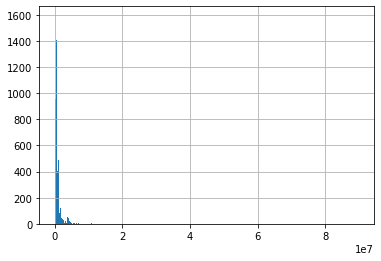

In [60]:
feature_info(cars.price)

Тип признака: float64
Значения признака:


count    1.085510e+05
mean     9.327871e+05
std      1.291907e+06
min      1.000000e+04
25%      3.100000e+05
50%      5.650000e+05
75%      1.046000e+06
max      9.000000e+07
Name: price, dtype: float64

Различных значений c учётом NaN: 9218
              	  без учёта NaN: 9217 
Пропусков: 1095
Значений, встретившихся в столбце более 10 раз: 1173


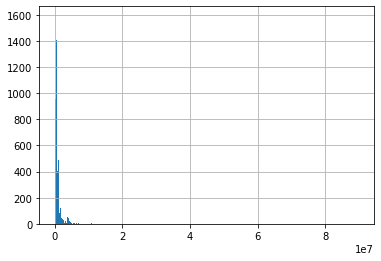

In [61]:
feature_info(cars.price)

In [62]:
cars.drop(['priceCurrency','href'], axis=1, inplace=True)

In [63]:
cars.head(10)

,brand,name,modelDate,color,productionDate,bodyType,fuelType,numberOfDoors,vehicleTransmission,engineDisplacement,whilleType,drive,enginePower,kmAge,place,VIN,seller,#owners,inUse,pts,condition,tax,castoms,exchange,price,num_options,led_lights,tyres_contol,elecrtic_back,electic_rear_seats,bottom_start,window_airbag,no_key,electrick_mirror,anti_crash,hsa,rain_control,leather,warm_wheel,light_control,premium_audio,line_control,rear_sits_memory,start_stop,leather_wheel,wheel_controls,navigation
0,BMW,BMW 5 серия VI (F10/F11/F07) 530d xDrive,2009,чёрный,2012,седан,дизель,4,автоматическая,3.0,Левый,полный,258,177000,Москва,X4X,Private,3,0,Оригинал,Не требует ремонта,38700,Растаможен,Нет,950000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,BMW,BMW 5 серия VII (G30/G31) 520d xDrive,2016,синий,2019,седан,дизель,4,автоматическая,2.0,Левый,полный,190,6000,Москва,X4X,Private,1,6,Оригинал,Не требует ремонта,10450,Растаможен,Нет,2745000.0,59,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,0,0,1,1,0,1
2,FIAT,Fiat 125,1967,жёлтый,1973,седан,бензин,4,механическая,1.6,Левый,задний,100,3600,Москва,XXX,Private,1,279,Оригинал,Не требует ремонта,1200,Растаможен,Нет,235000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,FORD,Ford Focus II Рестайлинг,2007,серебристый,2008,седан,бензин,4,механическая,1.8,Левый,передний,125,117246,Москва,WF0,Salon,2,0,Оригинал,Не требует ремонта,3125,Растаможен,Нет,325000.0,26,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,RENAULT,Renault Logan II Рестайлинг,2018,белый,2020,седан,бензин,4,механическая,1.6,Левый,передний,113,0,Химки,XXX,Salon,0,0,Оригинал,Другое,3842,Другое,Нет,749000.0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,VOLKSWAGEN,Volkswagen Polo V,2009,синий,2011,седан,бензин,4,автоматическая,1.6,Левый,передний,105,98414,Москва,XW8,Salon,1,0,Оригинал,Не требует ремонта,2625,Растаможен,Нет,415000.0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,CHEVROLET,Chevrolet Lacetti,2004,красный,2007,хэтчбек,бензин,5,механическая,1.6,Левый,передний,109,139727,Москва,XUU,Salon,3,0,Оригинал,Не требует ремонта,2725,Растаможен,Нет,255000.0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,MERCEDES,Mercedes-Benz B-Класс II (W246) 180,2011,белый,2013,хэтчбек,бензин,5,роботизированная,1.6,Левый,передний,122,200664,Москва,WDD,Private,1,83,Оригинал,Не требует ремонта,3050,Растаможен,Нет,580000.0,48,1,0,0,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,1,0,0
8,FORD,Ford Focus III,2011,чёрный,2012,хэтчбек,бензин,5,роботизированная,2.0,Левый,передний,150,690000,Москва,X9F,Private,3,0,Оригинал,Не требует ремонта,5250,Растаможен,Нет,425000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,MERCEDES,Mercedes-Benz V-Класс I (W638) 230,1996,фиолетовый,1998,минивэн,бензин,5,механическая,2.3,Левый,передний,143,270000,Москва,VSA,Private,3,0,Оригинал,Не требует ремонта,5005,Растаможен,Рассмотрю варианты,340000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
# fig, ax = plt.subplots(figsize=(10,10)) 
# sns.heatmap(cars.corr(), square=True,
#             annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")

Выводы: очень сильная корреляция: modelDate:productionDate, :kmAge, :#owners
                                  productionDate:modelDate, :kmAge, :#owners
                                  engineDisplacement:enginePower, tax
                                  kmAge:productionDate, :#owners

In [65]:
# cars.to_csv('d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200620_auto_bd_cleared.csv', sep=';', encoding='utf-8')

In [66]:
# Функция для поиска статистически значимых различий
def get_stat_dif(_column, _result_mark):
    cols = cars.loc[:, _column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(cars.loc[cars.loc[:, _column] == comb[0], _result_mark], 
                        cars.loc[cars.loc[:, _column] == comb[1], _result_mark]).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', _column)
            break

In [67]:
# Функция для визуализации зависимостей категориальных признаков
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='price', 
                data=cars,
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [68]:
# for col in ['brand', 'name', 'color', 'bodyType', 'fuelType', 'vehicleTransmission', 'whilleType', 'place', 'VIN',
#             'seller', 'pts', 'condition', 'castoms', 'exchange']:
#     get_boxplot(col)

In [69]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109646 entries, 0 to 125062
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                109646 non-null  object 
 1   name                 109646 non-null  object 
 2   modelDate            109646 non-null  int64  
 3   color                109646 non-null  object 
 4   productionDate       109646 non-null  int64  
 5   bodyType             109646 non-null  object 
 6   fuelType             109646 non-null  object 
 7   numberOfDoors        109646 non-null  int64  
 8   vehicleTransmission  109646 non-null  object 
 9   engineDisplacement   109646 non-null  float64
 10  whilleType           109646 non-null  object 
 11  drive                109572 non-null  object 
 12  enginePower          109646 non-null  int32  
 13  kmAge                109646 non-null  int32  
 14  place                109646 non-null  object 
 15  VIN              

In [70]:
# for col in cars.columns:
#     get_stat_dif(col, 'price')

In [71]:
corr_matrix = cars.corr()
corr_features = np.abs(corr_matrix[np.abs(corr_matrix.price)>0.00].price).sort_values(ascending=False)

In [72]:
corr_features

price                 1.000000
enginePower           0.624688
tax                   0.605521
engineDisplacement    0.451709
led_lights            0.417945
productionDate        0.413703
modelDate             0.410055
#owners               0.398558
tyres_contol          0.395320
kmAge                 0.385756
elecrtic_back         0.384050
bottom_start          0.370974
no_key                0.363517
electic_rear_seats    0.361049
window_airbag         0.360641
num_options           0.359911
warm_wheel            0.345225
hsa                   0.342483
rain_control          0.341150
electrick_mirror      0.333565
rear_sits_memory      0.327918
premium_audio         0.325586
light_control         0.323117
anti_crash            0.314398
leather               0.313653
navigation            0.305593
wheel_controls        0.299292
start_stop            0.294421
line_control          0.290798
leather_wheel         0.275044
numberOfDoors         0.107725
inUse                 0.105151
Name: pr

In [73]:
corr_matrix

,modelDate,productionDate,numberOfDoors,engineDisplacement,enginePower,kmAge,#owners,inUse,tax,price,num_options,led_lights,tyres_contol,elecrtic_back,electic_rear_seats,bottom_start,window_airbag,no_key,electrick_mirror,anti_crash,hsa,rain_control,leather,warm_wheel,light_control,premium_audio,line_control,rear_sits_memory,start_stop,leather_wheel,wheel_controls,navigation
modelDate,1.000000,0.897414,0.206151,0.060489,0.249781,-0.593813,-0.598877,-0.190551,0.137517,0.410055,0.368919,0.271842,0.310613,0.176026,0.158538,0.258862,0.274000,0.245901,0.235166,0.160500,0.337503,0.269335,0.150056,0.308683,0.285785,0.135397,0.127720,0.117343,0.149716,0.313537,0.173782,0.192663
productionDate,0.897414,1.000000,0.165464,-0.007169,0.159563,-0.720808,-0.682385,-0.218646,0.103557,0.413703,0.360443,0.283882,0.312572,0.176064,0.138869,0.257859,0.262848,0.243273,0.221714,0.165518,0.350038,0.254670,0.124637,0.312555,0.273047,0.128562,0.135321,0.109699,0.145141,0.291307,0.173114,0.181580
numberOfDoors,0.206151,0.165464,1.000000,0.113076,0.096208,-0.079850,-0.133213,-0.001775,0.030620,0.107725,0.121496,0.058836,0.061333,0.098230,0.052515,0.084466,0.100933,0.105557,0.106291,0.054827,0.102494,0.105781,0.070743,0.086155,0.101175,0.050295,0.041360,0.036076,0.009830,0.101000,0.025932,0.072256
engineDisplacement,0.060489,-0.007169,0.113076,1.000000,0.851080,0.064449,0.034246,0.040538,0.631526,0.451709,0.176564,0.119875,0.153806,0.247150,0.365011,0.195450,0.195856,0.229267,0.215672,0.133732,0.118773,0.208539,0.365775,0.156443,0.194653,0.260861,0.147829,0.309187,0.132874,0.142149,0.130020,0.257660
enginePower,0.249781,0.159563,0.096208,0.851080,1.000000,-0.066113,-0.062004,-0.007970,0.793334,0.624688,0.280999,0.227102,0.276400,0.332688,0.416190,0.281557,0.300264,0.297231,0.291464,0.201032,0.212124,0.316372,0.404820,0.248214,0.294324,0.325622,0.181110,0.355720,0.254552,0.241296,0.232174,0.306969
kmAge,-0.593813,-0.720808,-0.079850,0.064449,-0.066113,1.000000,0.646855,0.161157,-0.071934,-0.385756,-0.295088,-0.279020,-0.293503,-0.154211,-0.099790,-0.232151,-0.218798,-0.219150,-0.183063,-0.154986,-0.323447,-0.199324,-0.079087,-0.286808,-0.219402,-0.108750,-0.131836,-0.089210,-0.126224,-0.230687,-0.162641,-0.145245
#owners,-0.598877,-0.682385,-0.133213,0.034246,-0.062004,0.646855,1.000000,0.098405,-0.046506,-0.398558,-0.330518,-0.317807,-0.325689,-0.160701,-0.105657,-0.250407,-0.236299,-0.233298,-0.204216,-0.177813,-0.365625,-0.204625,-0.085359,-0.312845,-0.227153,-0.107514,-0.150082,-0.075186,-0.104309,-0.255612,-0.167841,-0.136664
inUse,-0.190551,-0.218646,-0.001775,0.040538,-0.007970,0.161157,0.098405,1.000000,-0.011859,-0.105151,-0.004674,-0.077464,-0.081745,-0.040904,0.012613,-0.052671,-0.006962,-0.041760,0.004037,-0.050471,-0.052427,-0.045482,0.004643,-0.074280,-0.051084,0.013053,-0.038678,-0.009032,-0.029850,0.014828,-0.035484,-0.008675
tax,0.137517,0.103557,0.030620,0.631526,0.793334,-0.071934,-0.046506,-0.011859,1.000000,0.605521,0.199486,0.179767,0.214032,0.284981,0.320977,0.206666,0.202948,0.221755,0.196882,0.180479,0.147304,0.213679,0.298515,0.178139,0.188300,0.289111,0.188996,0.326840,0.214018,0.147467,0.191123,0.253633
price,0.410055,0.413703,0.107725,0.451709,0.624688,-0.385756,-0.398558,-0.105151,0.605521,1.000000,0.359911,0.417945,0.395320,0.384050,0.361049,0.370974,0.360641,0.363517,0.333565,0.314398,0.342483,0.341150,0.313653,0.345225,0.323117,0.325586,0.290798,0.327918,0.294421,0.275044,0.299292,0.305593


In [74]:
for index in corr_matrix.index:
    for column in corr_matrix.columns:
        if corr_matrix[index][column]>0.7 and index!=column:
            print (index, column, corr_matrix[index][column])

modelDate productionDate 0.8974141352903511
productionDate modelDate 0.8974141352903511
engineDisplacement enginePower 0.8510803456830733
enginePower engineDisplacement 0.8510803456830733
enginePower tax 0.7933339009391074
tax enginePower 0.7933339009391074
num_options window_airbag 0.7404182081667867
num_options hsa 0.709964467122931
num_options rain_control 0.7243842325915424
num_options light_control 0.7381633317313343
num_options leather_wheel 0.8142204845377901
bottom_start no_key 0.769364781999196
window_airbag num_options 0.7404182081667867
no_key bottom_start 0.769364781999196
hsa num_options 0.709964467122931
rain_control num_options 0.7243842325915424
rain_control light_control 0.8668735228453803
light_control num_options 0.7381633317313343
light_control rain_control 0.8668735228453803
leather_wheel num_options 0.8142204845377901


In [75]:
cars['total_tax'] = cars.inUse*cars['tax']/12
cars['km_per_month'] = cars['kmAge']/((2020 - cars['productionDate'])*12+1)
cars.drop(['modelDate'], axis=1, inplace = True)
# 'led_lights','tyres_contol', 'elecrtic_back', 'electic_rear_seats', 'bottom_start', 'window_airbag',
#                'no_key', 'electrick_mirror', 'anti_crash', 'hsa', 'rain_control', 'leather', 'warm_wheel', 'light_control',
#                'premium_audio', 'line_control', 'rear_sits_memory', 'start_stop', 'leather_wheel', 'wheel_controls',
#                 'navigation'

In [76]:
cars.dropna(inplace = True)
cars.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 108477 entries, 0 to 125062
Data columns (total 48 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   brand                108477 non-null  object 
 1   name                 108477 non-null  object 
 2   color                108477 non-null  object 
 3   productionDate       108477 non-null  int64  
 4   bodyType             108477 non-null  object 
 5   fuelType             108477 non-null  object 
 6   numberOfDoors        108477 non-null  int64  
 7   vehicleTransmission  108477 non-null  object 
 8   engineDisplacement   108477 non-null  float64
 9   whilleType           108477 non-null  object 
 10  drive                108477 non-null  object 
 11  enginePower          108477 non-null  int32  
 12  kmAge                108477 non-null  int32  
 13  place                108477 non-null  object 
 14  VIN                  108477 non-null  object 
 15  seller           

In [77]:
cars.to_csv("d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200629_auto_bd_do_Omska_categorial.csv", sep=';', encoding='utf-8', index=False)

### Преобразуем текстовые признаки в категориальные

In [78]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cars.brand = cars.brand.astype('category')
cars.brand = encoder.fit_transform(cars.brand)

In [79]:
cars.name = cars.name.astype('category')
cars.name = encoder.fit_transform(cars.name)

In [80]:
cars.place = cars.place.astype('category')
cars.place = encoder.fit_transform(cars.place)

In [81]:
cars.VIN = cars.name.astype('category')
cars.VIN = encoder.fit_transform(cars.VIN)

In [82]:
cars.color = cars.color.astype('category')
cars.color = encoder.fit_transform(cars.color)

In [83]:
cars.bodyType = cars.bodyType.astype('category')
cars.bodyType = encoder.fit_transform(cars.bodyType)

In [84]:
cars.fuelType = cars.fuelType.astype('category')
cars.fuelType = encoder.fit_transform(cars.fuelType)

In [85]:
cars.vehicleTransmission = cars.vehicleTransmission.astype('category')
cars.vehicleTransmission = encoder.fit_transform(cars.vehicleTransmission)

In [86]:
cars.whilleType = cars.whilleType.astype('category')
cars.whilleType = encoder.fit_transform(cars.whilleType)

In [87]:
cars.drive = cars.drive.astype('category')
cars.drive.fillna('передний', inplace=True)
cars.drive = encoder.fit_transform(cars.drive)

In [88]:
cars.seller = cars.seller.astype('category')
cars.seller = encoder.fit_transform(cars.seller)

In [89]:
cars.pts = cars.pts.astype('category')
cars.pts = encoder.fit_transform(cars.pts)
cars.condition = cars.condition.astype('category')
cars.condition = encoder.fit_transform(cars.condition)
cars.castoms = cars.castoms.astype('category')
cars.castoms = encoder.fit_transform(cars.castoms)
cars.exchange = cars.exchange.astype('category')
cars.exchange = encoder.fit_transform(cars.exchange)

In [90]:
cars.head(10)

,brand,name,color,productionDate,bodyType,fuelType,numberOfDoors,vehicleTransmission,engineDisplacement,whilleType,drive,enginePower,kmAge,place,VIN,seller,#owners,inUse,pts,condition,tax,castoms,exchange,price,num_options,led_lights,tyres_contol,elecrtic_back,electic_rear_seats,bottom_start,window_airbag,no_key,electrick_mirror,anti_crash,hsa,rain_control,leather,warm_wheel,light_control,premium_audio,line_control,rear_sits_memory,start_stop,leather_wheel,wheel_controls,navigation,total_tax,km_per_month
0,7,300,15,2012,14,3,4,0,3.0,0,3,258,177000,147,300,0,3,0,1,2,38700,1,0,950000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1824.742268
1,7,311,13,2019,14,3,4,0,2.0,0,3,190,6000,147,311,0,1,6,1,2,10450,1,0,2745000.0,59,1,1,1,0,1,1,1,1,0,1,1,0,1,1,1,0,0,1,1,0,1,5225.000000,461.538462
2,29,844,3,1973,14,0,4,2,1.6,0,1,100,3600,147,844,0,1,279,1,2,1200,1,0,235000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27900.000000,6.371681
3,30,918,11,2008,14,0,4,2,1.8,0,2,125,117246,147,918,1,2,0,1,2,3125,1,0,325000.0,26,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.000000,808.593103
4,80,2889,1,2020,14,0,4,2,1.6,0,2,113,0,280,2889,1,0,0,1,1,3842,0,0,749000.0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
5,102,3622,13,2011,14,0,4,0,1.6,0,2,105,98414,147,3622,1,1,0,1,2,2625,1,0,415000.0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,902.880734
6,14,651,7,2007,21,0,5,2,1.6,0,2,109,139727,147,651,1,3,0,1,2,2725,1,0,255000.0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,889.980892
7,66,1885,1,2013,21,0,5,3,1.6,0,2,122,200664,147,1885,0,1,83,1,2,3050,1,0,580000.0,48,1,0,0,0,0,1,0,1,1,1,1,1,0,1,0,0,0,1,1,0,0,21095.833333,2360.752941
8,30,919,15,2012,21,0,5,3,2.0,0,2,150,690000,147,919,0,3,0,1,2,5250,1,0,425000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,7113.402062
9,66,2277,14,1998,9,0,5,2,2.3,0,2,143,270000,147,2277,0,3,0,1,2,5005,1,1,340000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1018.867925


In [91]:
cars.to_csv('d:\\skillfactory\\Real Data Science\\4.Auto_pickup\\200629_auto_bd_do_Omska_cleared.csv', sep=';', 
            encoding='utf-8', index=False)